
   HYBRID GRADIENT BOOSTING (Research + Local)
1. Training Base Model (Standard GB)...
   > Base Model MAE: 7.21 MPa

2. Training Correction Model (Full Environmental Factors)...
   > Using Correction Features: ['Rainfall_Code', 'AvgTemp_0to28', 'GDD_28', 'TotalRainfall_28', 'AvgHumidity_28']
   > Running Grid Search...
   > Best Settings Found: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.7}

3. Validating Full System...
------------------------------
   > R² Score:   -17.2038
   > MAE:        8.0246 MPa
   > MSE:        89.8526
   > RMSE:       9.4791 MPa
   > MAPE:       21.73%
------------------------------


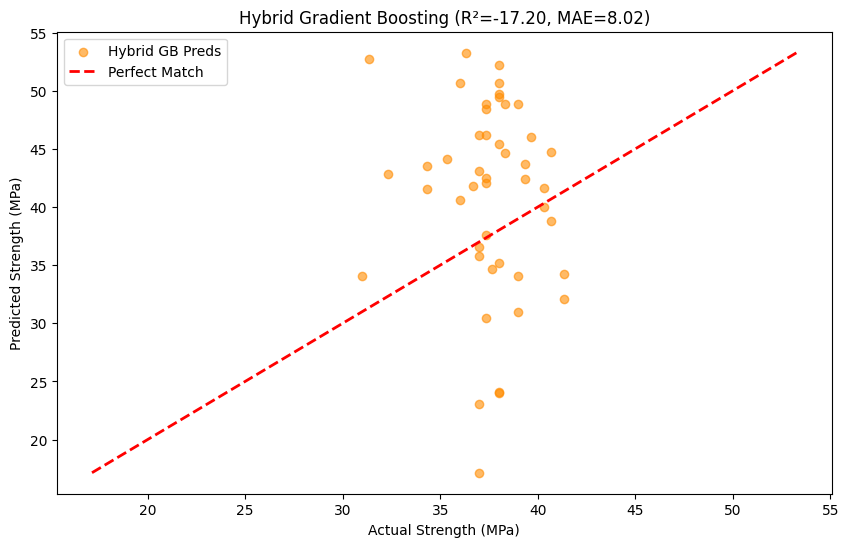

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# --- 1. LOAD DATA ---
df_kaggle = pd.read_csv("Data/zainfaisal_pakistan_concrete_data.csv")
df_local = pd.read_csv("Data/localdataset.csv")

# Clean names
df_kaggle.columns = df_kaggle.columns.str.strip()
df_local.columns = df_local.columns.str.strip()

# --- 2. HELPER FUNCTION (Unchanged) ---
def train_helper_data(df):
    recipe_cols = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 
                   'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate']
    
    # Train Helper
    df_7 = df[df['Age'] == 7].copy()
    X_helper = df_7[recipe_cols]
    y_helper = df_7['Strength']
    
    helper_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    helper_model.fit(X_helper, y_helper)

    # Impute
    df_28 = df[df['Age'] == 28].copy()
    df_28['Predicted_Strength_7'] = helper_model.predict(df_28[recipe_cols])
    
    df_7_grouped = df_7.groupby(recipe_cols)['Strength'].mean().reset_index()
    df_7_grouped = df_7_grouped.rename(columns={'Strength': 'Real_Strength_7'})
    
    df_augmented = pd.merge(df_28, df_7_grouped, on=recipe_cols, how='left')
    df_augmented['Strength_7'] = df_augmented['Real_Strength_7'].fillna(df_augmented['Predicted_Strength_7'])
    
    final_dataset = df_augmented[['Strength_7', 'Strength']].copy().rename(columns={'Strength': 'Strength_28'})
    return final_dataset

# --- 3. HYBRID GRADIENT BOOSTING PIPELINE ---
def process_hybrid_gradient_boosting(df_helper, df_local):
    print("\n" + "="*40)
    print("   HYBRID GRADIENT BOOSTING (Research + Local)")
    print("="*40)

    # A. TRAIN BASE MODEL (Research Data)
    print("1. Training Base Model (Standard GB)...")
    X_base = df_helper[['Strength_7']]
    y_base = df_helper['Strength_28']
    
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
    
    # Standard GB for Base
    base_model = GradientBoostingRegressor(
        n_estimators=500,       
        learning_rate=0.05, 
        max_depth=4,            
        random_state=42
    )
    base_model.fit(X_train_b, y_train_b)
    
    base_preds = base_model.predict(X_test_b)
    print(f"   > Base Model MAE: {mean_absolute_error(y_test_b, base_preds):.2f} MPa")

    # B. TRAIN CORRECTION MODEL (Local Data with LATEST FEATURES)
    print("\n2. Training Correction Model (Full Environmental Factors)...")
    
    # 1. Base Prediction & Residual
    df_local['Base_Pred_Lab'] = base_model.predict(df_local[['Strength_7']])
    df_local['Residual'] = df_local['Strength_28'] - df_local['Base_Pred_Lab']
    
    # 2. Latest Features
    correction_features = [
        'Rainfall_Code',       # Rain on casting day
        'AvgTemp_0to28',       # Avg temp during curing
        'GDD_28',              # Growing Degree Days
        'TotalRainfall_28',    # Accumulated Rain
        'AvgHumidity_28'       # Average Humidity
    ]
    
    available_features = [c for c in correction_features if c in df_local.columns]
    print(f"   > Using Correction Features: {available_features}")
    
    X_corr = df_local[available_features]
    y_corr = df_local['Residual']
    
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_corr, y_corr, test_size=0.2, random_state=42)
    
    # 3. Grid Search for Gradient Boosting
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3],        # Shallow trees to avoid overfitting local data
        'subsample': [0.7, 0.9]     # Stochastic gradient boosting (adds robustness)
    }
    
    print("   > Running Grid Search...")
    gb_search = GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=3, 
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    gb_search.fit(X_train_c, y_train_c)
    
    correction_model = gb_search.best_estimator_
    print(f"   > Best Settings Found: {gb_search.best_params_}")

    # C. FINAL VALIDATION
    print("\n3. Validating Full System...")
    
    # Base Part
    test_inputs_base = df_local.loc[X_test_c.index, ['Strength_7']]
    pred_base_part = base_model.predict(test_inputs_base)
    
    # Correction Part
    test_inputs_corr = X_test_c
    pred_corr_part = correction_model.predict(test_inputs_corr)
    
    # Combine
    final_predictions = pred_base_part + pred_corr_part
    actual_values = df_local.loc[X_test_c.index, 'Strength_28']
    
    # --- METRICS ---
    final_mae = mean_absolute_error(actual_values, final_predictions)
    final_mse = mean_squared_error(actual_values, final_predictions)
    final_rmse = np.sqrt(final_mse)
    final_r2 = r2_score(actual_values, final_predictions)
    final_mape = mean_absolute_percentage_error(actual_values, final_predictions)
    
    print("-" * 30)
    print(f"   > R² Score:   {final_r2:.4f}")
    print(f"   > MAE:        {final_mae:.4f} MPa")
    print(f"   > MSE:        {final_mse:.4f}")
    print(f"   > RMSE:       {final_rmse:.4f} MPa")
    print(f"   > MAPE:       {final_mape:.2%}")
    print("-" * 30)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, final_predictions, color='darkorange', alpha=0.6, label='Hybrid GB Preds')
    min_val = min(min(actual_values), min(final_predictions))
    max_val = max(max(actual_values), max(final_predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Match')
    plt.xlabel("Actual Strength (MPa)")
    plt.ylabel("Predicted Strength (MPa)")
    plt.title(f"Hybrid Gradient Boosting (R²={final_r2:.2f}, MAE={final_mae:.2f})")
    plt.legend()
    plt.show()
    
    return base_model, correction_model

# --- 5. EXECUTE ---
df_helper = train_helper_data(df_kaggle)
base_model_gb, correction_model_gb = process_hybrid_gradient_boosting(df_helper, df_local)